In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-01-29 19:32:56--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-29 19:32:56--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.08MB/s    in 2m 40s  

2022-01-29 19:35:36 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import string
import re
import nltk
import pickle
import time
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim import corpora
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import recall_score,f1_score,precision_score,classification_report,roc_curve,auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from torchtext.legacy import data

Read dataset files

In [ ]:
train_set = pd.read_csv("vaccine_train_set.csv") #read train data set
validation_set = pd.read_csv("vaccine_validation_set.csv") #read validation data set

# train_set.head()
train_set = train_set.drop(columns=['Unnamed: 0'])
validation_set = validation_set.drop(columns=['Unnamed: 0'])

#PREPROCESSING

In [ ]:
nltk.download('stopwords')
stopwords = stopwords.words('english')
 
def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    t = tweet.lower() #convert to lower case
    t = re.sub("'", "", t) # to avoid removing contractions in english
    t = re.sub("@[A-Za-z0-9_]+","", t) #removes tags
    t = re.sub("#[A-Za-z0-9_]+","", t) #removes hashtags
    t = re.sub(r'http\S+', '', t) #remove links
    t = re.sub('[()!?]', ' ', t)  #remove punctuation
    t = re.sub('\[.*?\]',' ', t)
    t = re.sub("[^a-z0-9]"," ", t) #remove numbers
    t = t.split() #splits the tweet to individual words
    t = [w for w in t if not w in stopwords] #remove stopwords
    t = " ".join(word for word in t)
    return t

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preprocess datasets

In [ ]:
torch.manual_seed(185)
#filter tweets
train_set['tweet'] = train_set['tweet'].apply(lambda tw: clean_tweet(tw)) #clean tweets
validation_set['tweet'] = validation_set['tweet'].apply(lambda tw: clean_tweet(tw)) #clean tweets
#delete emtpy tweets
train_set = train_set.drop(train_set[train_set['tweet'].map(lambda x: str(x)=='' )].index)
validation_set = validation_set.drop(validation_set[validation_set['tweet'].map(lambda x: str(x)=='' )].index)

Convert and save preprocessed dataset to csv files

In [ ]:
train_set.to_csv("/content/train.csv", index=False)
validation_set.to_csv("/content/validation.csv", index=False)

Define TEXT and LABEL from torchtext.data

In [ ]:
TEXT = data.Field(dtype=torch.long, tokenize="spacy",batch_first=True)
LABEL = data.LabelField(dtype=torch.long, sequential=False)
fields = [('text', TEXT), ('label', LABEL)]

Load preprocessed dataset files

In [ ]:
train_data, validation_data= data.TabularDataset.splits( 
    path="/content/", 
    train="train.csv", 
    validation="validation.csv", 
    format="csv", 
    skip_header=True, 
    fields = fields)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(validation_data)}')

Number of training examples: 15940
Number of valid examples: 2276


#VECTORIZATION

In [ ]:
#get Glove files
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

Build vocabulary

In [ ]:
vectors = torchtext.vocab.Vectors(name='glove.6B.300d.txt')
TEXT.build_vocab(train_data, vectors=torchtext.vocab.Vectors("/content/glove.6B.300d.txt"),max_size=20000,min_freq=1)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {TEXT.vocab.itos}")
print(f"Unique tokens in LABEL vocabulary: {LABEL.vocab.itos}")

100%|█████████▉| 399999/400000 [00:45<00:00, 8764.41it/s]


Unique tokens in TEXT vocabulary: 16608
Unique tokens in LABEL vocabulary: 3
Unique tokens in LABEL vocabulary: ['<unk>', '<pad>', 'vaccine', 'measles', 'nt', 'vaccines', 'kids', 'health', 'get', 'covid', 'people', 'children', 'vaccinate', '19', 'do', 'vaccinated', 'amp', 'immunity', 'mmr', 'autism', 'outbreak', 'i', 'vaccination', 'vaccinations', 'parents', 'flu', 'school', 'm', 'child', 'like', 'cases', 'news', 'got', 'one', 'disease', 's', 'new', 'pfizer', 'first', 'would', 'us', '2', 'good', 'getting', 'effective', 'take', 'know', 'via', 'cause', 'need', 'officials', 'u', 'live', 'coronavirus', 'diseases', 'anti', 'think', 'say', '1', 'says', 'county', 'disneyland', 'immunization', 'still', 'baby', 'cdc', 'could', 'go', 'rt', 'time', 'year', 'risk', 'safe', 'today', 'virus', 'back', 'make', 'case', 'may', 'want', '4', 'public', '90', 'ca', 'longer', 'shot', 'vaccinating', 'day', 'california', 'ebola', 'increases', 'complain', 'going', 'study', 'immunizations', 'even', 'tension', 'r

Get device(cuda)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: " , device)

Device available for running:  cpu


#MODEL DEFINITION (LSTM)

BucketIterator

In [ ]:
BATCH_SIZE = 32

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, validation_data), 
    sort_key=lambda x: len(x.text),
    batch_size=BATCH_SIZE,
    shuffle=True,
    device=device,
    sort_within_batch=True,
    sort=False)

Utility function for training and validation

In [31]:
def train(model, train_iterator, valid_iterator, epochs, lr):
    criterion = nn.CrossEntropyLoss() #loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #optimizer
    train_losses, valid_losses = [], [] #stores all the losses for all epochs (needed for learning curves)
    # epochs_num = []
    for epoch in range(epochs):
        
        epoch_train_loss, epoch_valid_loss = [] , [] #arrays to store looses per epoch

        #train process
        model.train()
        for tweets, labels in train_iterator:
            optimizer.zero_grad()
            predictions = model(tweets)
            train_loss = criterion(predictions, labels)
            train_loss.backward()

            epoch_train_loss.append(float(train_loss))

            #Gradient Value Clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5, norm_type=2)
            # for layer in model.ordered_layers:
            # norm_grad = model.linear.weight.grad.norm()
            # print('norm:' , norm_grad.item())

            optimizer.step()
        
        train_losses.append(sum(epoch_train_loss)/len(train_iterator))

        #validation process
        with torch.no_grad():
          for tweets, labels in valid_iterator:
              preds = model(tweets)
              val_loss = criterion(preds, labels)
              epoch_valid_loss.append(float(val_loss))

        valid_losses.append(sum(epoch_valid_loss)/len(valid_iterator))
        
        print('epoch: ',epoch, ' train_loss: ', sum(epoch_train_loss)/len(train_iterator), 
              ' val_loss: ', sum(epoch_valid_loss)/len(valid_iterator))
    
    # plotting Learning curves
    plt.title("loss vs. epochs curve")
    plt.ylim(0,2)
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")


Actual model definition class

Non-attention model

In [45]:
class network(nn.Module):
    def __init__(self, input_size, hidden_size, n_labels,n_layers,cell_type):
        super(network, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(TEXT.vocab.vectors.to(device) )
        self.hidden = hidden_size

        if cell_type == "LSTM":
          self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True,batch_first=True,num_layers=n_layers)
        else:
          self.rnn = nn.GRU(input_size, hidden_size, bidirectional=True,batch_first=True,num_layers=n_layers)

        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_size*2, n_labels)
        
    def forward(self, input):
        input = self.embedding(input)
        hidden_0 = torch.zeros(n_layers * 2, input.size(0), self.hidden)
        if cell_type == "LSTM":
          cell_0 = torch.zeros(n_layers * 2, input.size(0), self.hidden)
          out_rnn, _ = self.rnn(input, (hidden_0.to(device), cell_0.to(device)))
        else:
          out_rnn, _ = self.rnn(input,hidden_0.to(device))

        out = self.dropout(out_rnn)
        out = self.linear(out[:, -1, :])

        return out

Attention model

In [32]:
class network(nn.Module):
    def __init__(self, input_size, hidden_size, n_labels,n_layers,cell_type):
        super(network, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(TEXT.vocab.vectors.to(device) )
        self.hidden = hidden_size

        if cell_type == "LSTM":
          self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True,batch_first=True,num_layers=n_layers)
        else:
          self.rnn = nn.GRU(input_size, hidden_size, bidirectional=True,batch_first=True,num_layers=n_layers)

        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh()
        self.soft = nn.Softmax()

        self.linear = nn.Linear(hidden_size*2, n_labels)
        
    def forward(self, input):
        input = self.embedding(input)
        hidden_0 = torch.zeros(n_layers * 2, input.size(0), self.hidden)
        if cell_type == "LSTM":
          cell_0 = torch.zeros(n_layers * 2, input.size(0), self.hidden)
          out_rnn, _ = self.rnn(input, (hidden_0.to(device), cell_0.to(device)))
        else:
          out_rnn, _ = self.rnn(input,hidden_0.to(device))
        out_rnn = self.dropout(out_rnn)

        # print(out_rnn.shape)
        # print(out_rnn[:, -1, :].shape)
        out = torch.bmm(out_rnn,out_rnn[:, -1, :].unsqueeze(2))
        out = self.tanh(out)

        out = self.soft(out)
        output = out*out_rnn
        # print(output.shape)
        out=self.linear(torch.sum(output,axis=1))

        # out = self.linear(out[:, -1, :])

        return out

#TRAINING / VALIDATION

network(
  (embedding): Embedding(16608, 300)
  (rnn): LSTM(300, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)
epoch:  0  train_loss:  1.0451494166272914  val_loss:  0.9882591043909391
epoch:  1  train_loss:  0.9519106884279805  val_loss:  0.8971400145027373
epoch:  2  train_loss:  0.8574080155464355  val_loss:  0.828656479716301
epoch:  3  train_loss:  0.8174555701817683  val_loss:  0.8043820874558555
epoch:  4  train_loss:  0.7964215001505697  val_loss:  0.7921977721982532
epoch:  5  train_loss:  0.7819165270290298  val_loss:  0.7797358880440394
epoch:  6  train_loss:  0.7686919003784776  val_loss:  0.7682704197035896
epoch:  7  train_loss:  0.7575062295955742  val_loss:  0.7620654015077485
epoch:  8  train_loss:  0.746850277653677  val_loss:  0.7519252341654565
epoch:  9  train_loss:  0.7367274017037753  val_loss:  0.7472522705793381
epoch:  10  train_loss:  0.72884

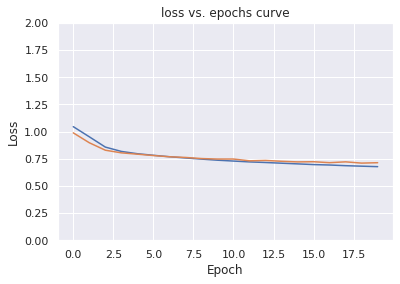

In [46]:
#Hyperparameters
EMBEDDING_SIZE = TEXT.vocab.vectors.shape[1] #50 dimensions
HIDDEN_SIZE = 128
# learning_rate = 0.00002
learning_rate = 0.000015
n_layers = 2
epochs = 20
cell_type = "LSTM" #LSTM or GRU

model = network(EMBEDDING_SIZE, HIDDEN_SIZE, 3, n_layers, cell_type)
model = model.to(device)
print(model)
train(model, train_iterator, valid_iterator, epochs, learning_rate)

#F1_score

In [47]:
#validation process
true_labels ,pred_labels = [] , []
with torch.no_grad():
  for tweets, labels in valid_iterator:
      preds = model(tweets)
      #store labes for F1
      true_labels.append(labels)
      _, predicted = torch.max(preds, 1)#keep the label with the greatest propability
      pred_labels.append(predicted)

In [48]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import itertools
import numpy

#utility function to flaten a list and convert to a numpy array
def convert(array):
  pred_list=[]
  for i in array:
    pred_list.append(i.tolist())
  merged_pred = list(itertools.chain(*pred_list))
  predicted_labels = numpy.array(merged_pred)
  return predicted_labels

#Calculate F1 score for validaion dataset
true_labels = convert(true_labels)
pred_labels = convert(pred_labels)
print("PRECISSION SCORE =",precision_score(true_labels, pred_labels, average='weighted'))
print("RECALL SCORE =",recall_score(true_labels, pred_labels,average='weighted'))
print("F1 SCORE = ",f1_score(true_labels, pred_labels, average='weighted'))

PRECISSION SCORE = 0.6900861935828216
RECALL SCORE = 0.6942003514938488
F1 SCORE =  0.684023398294041


In [49]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1062
           1       0.64      0.77      0.70       920
           2       0.53      0.27      0.36       294

    accuracy                           0.69      2276
   macro avg       0.65      0.59      0.61      2276
weighted avg       0.69      0.69      0.68      2276



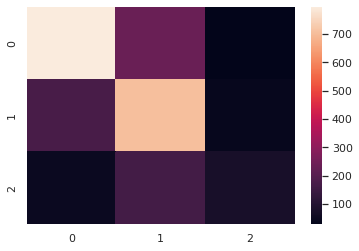

In [50]:
from sklearn.metrics import confusion_matrix
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
results = confusion_matrix(true_labels, pred_labels)
ax = sns.heatmap(results)

#ROC curve

In [51]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


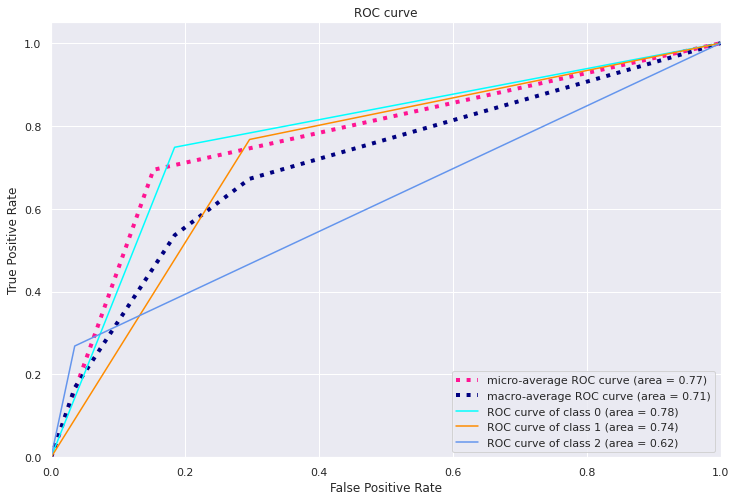

In [52]:
n_classes=3
y_true_binarized = label_binarize(true_labels, classes=[0,1,2])
y_pred_binarized = label_binarize(pred_labels, classes=[0,1,2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        # lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
# plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()